![AIcrowd-Logo](https://raw.githubusercontent.com/AIcrowd/AIcrowd/master/app/assets/images/misc/aicrowd-horizontal.png)


# Baseline for [SNAKE Challenge](https://www.aicrowd.com/challenges/snake) on AIcrowd

# Downloads and Installs

In [ ]:
!wget -q https://datasets.aicrowd.com/default/aicrowd-practice-challenges/public/snake/v0.1/train.zip
!wget -q https://datasets.aicrowd.com/default/aicrowd-practice-challenges/public/snake/v0.1/val.zip
!wget -q https://datasets.aicrowd.com/default/aicrowd-practice-challenges/public/snake/v0.1/test.zip

In [ ]:
!wget -q https://datasets.aicrowd.com/default/aicrowd-practice-challenges/public/snake/v0.1/sample_submission.csv

In [ ]:
!mkdir data
!mkdir data/test
!mkdir data/train
!mkdir data/val

In [ ]:
!unzip -q train.zip
!unzip -q test.zip
!unzip -q val.zip

In [ ]:
!mv content/data/train/* data/train
!mv content/data/val/* data/val
!mv content/data/test/* data/test

In [ ]:
!rm -rf content/

In [ ]:
!mkdir models

# Imports

In [ ]:
import sys
import os
import gc
import warnings
import torch

import torch.nn as nn
import numpy as np
import pandas as pd 
import torch.nn.functional as F

from fastai.script import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastprogress import fastprogress
from torchvision.models import *
from tqdm.notebook import tqdm

In [ ]:
np.random.seed(23)
torch.cuda.device(0)
warnings.filterwarnings("ignore")
torch.multiprocessing.freeze_support()
print("[INFO] GPU:", torch.cuda.get_device_name())

[INFO] GPU: Tesla K80


# Verify Images

In [ ]:
def verify_folder(path):
    p = Path(path)
    classes=['venomous','non_venomous']
    for c in classes:
            print(c)
            verify_images(p/c, delete=True)


In [ ]:
verify_folder("data/train")
verify_folder("data/val")

In [ ]:
# verify images for test
p = Path("data/test")
verify_images(p, delete=True)

# DataBunch and Model

Here we use a technique called progressive resizing. At each step the model is loaded with weights trained on images of lower sizes.

In [ ]:
def get_data(size, batch_size):
  """
  function that returns a DataBunch as needed for the Learner
  """
  tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=10.0, 
                      max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75)

  src = (ImageList.from_folder("data/train").split_none().label_from_folder())
  src.valid = (ImageList.from_folder("data/val").split_none().label_from_folder()).train
  src = src.transform(tfms, size=size)
  src.test = (ImageList.from_folder("data/test/").split_none()).train
  data = (src.databunch(num_workers=0, bs=batch_size).normalize(imagenet_stats))    
  print("[INFO] Number of Classes: ", data.c)
  data.num_workers = 4
  return data

[INFO] Number of Classes:  2


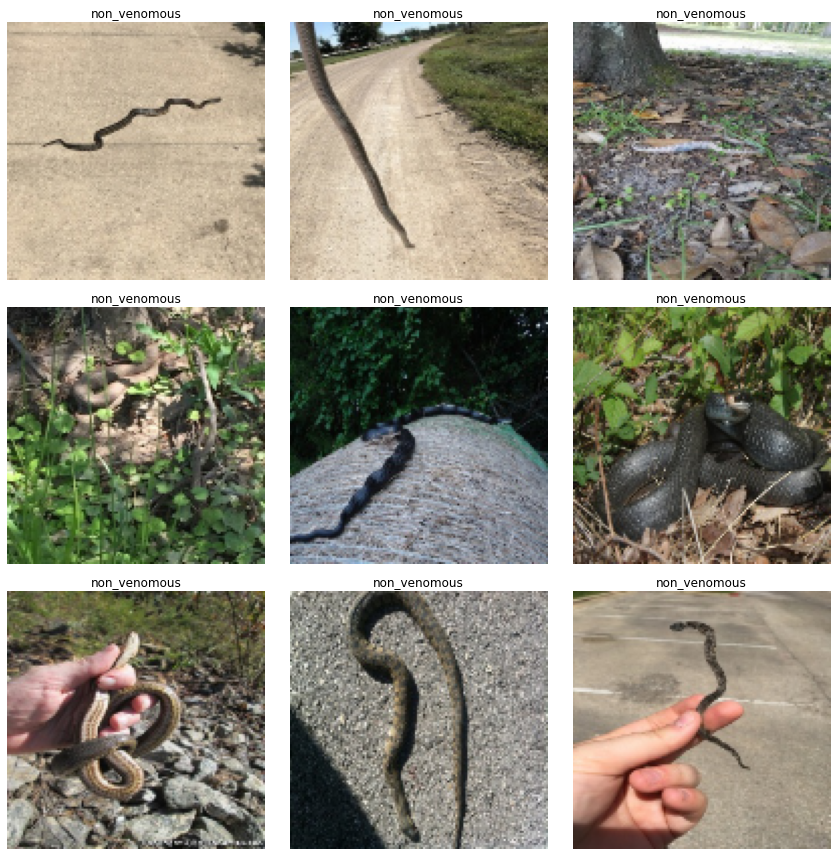

In [ ]:
sample_data = get_data(128, (2048//128))
sample_data.show_batch(3, 3)

As you can see, the transforms have been applied and the image is normalized as well!

We first initialize all the models.

In [ ]:
learn = create_cnn(get_data(128, (2048//128)), models.resnet18, 
                   metrics=[accuracy, FBeta(beta=1,average='macro')])
learn.model_dir = "models/"
learn.save("resnet_128")
learn = create_cnn(get_data(224, (2048//224)), models.resnet18, 
                   metrics=[accuracy, FBeta(beta=1,average='macro')]).load("resnet_128")
learn.model_dir = "models/"
learn.save("resnet_224")

[INFO] Number of Classes:  2


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



[INFO] Number of Classes:  2


In [ ]:
def train_model(size, iter1, iter2):
  """
  function to quickly train a model for a certain number of iterations.
  """
  size_match = {"224": "128"}
  learn = create_cnn(get_data(size, (2048//size)), models.densenet161, 
                     metrics=[accuracy, 
                              FBeta(beta=1,average='macro')])
  learn.model_dir = "models/"
  if str(size) != str(128):
    learn.load("resnet_" + str(size_match[str(size)]))

  name = "resnet_" + str(size)
  print("[INFO] Training for : ", name)

  learn.fit_one_cycle(iter1, 1e-4, callbacks=[ShowGraph(learn),
                            SaveModelCallback(learn, monitor='f_beta', mode='max', name=name)])
  learn.unfreeze()
  learn.fit_one_cycle(iter2, 5e-5, callbacks=[ShowGraph(learn),
                            SaveModelCallback(learn, monitor='f_beta', mode='max', name=name)])

In [ ]:
train_model(128, 2, 1)

[INFO] Number of Classes:  2
[INFO] Training for :  resnet_224


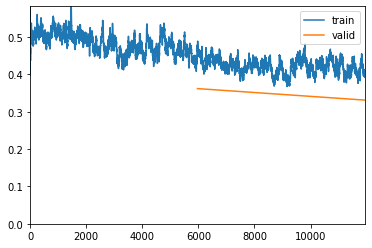

Better model found at epoch 0 with f_beta value: 0.829670786857605.
Better model found at epoch 1 with f_beta value: 0.8502123355865479.


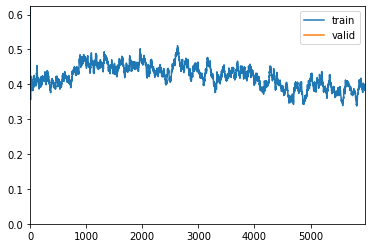

Better model found at epoch 0 with f_beta value: 0.8577048182487488.


In [ ]:
train_model(224, 2, 1)

[INFO] Number of Classes:  2


None

None

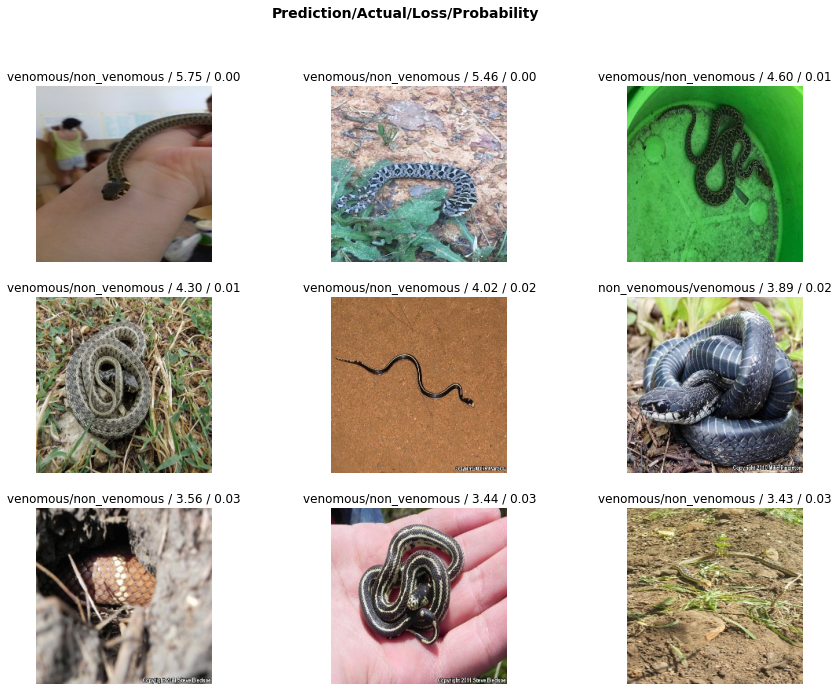

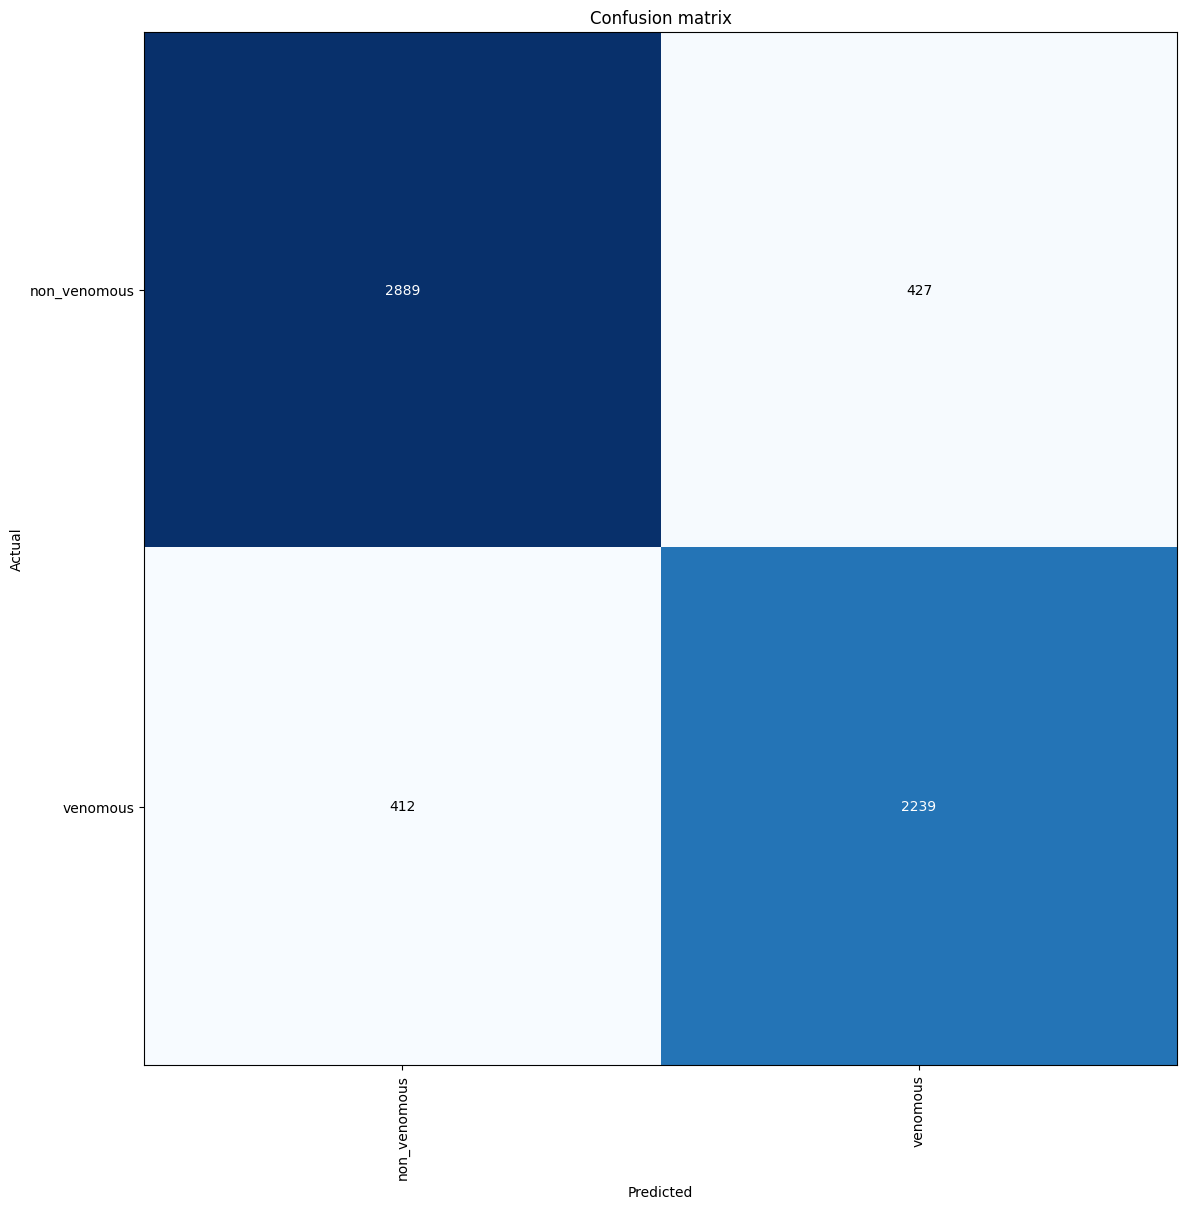

In [ ]:
size = 224
learn = create_cnn(get_data(size, (2048//size)), models.densenet161, 
                     metrics=[accuracy, 
                              FBeta(beta=1,average='macro')])
learn.model_dir = "models/"
learn.load("resnet_224")
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()

display(interp.plot_top_losses(9, figsize=(15,11)))
display(interp.plot_confusion_matrix(figsize=(12,12), dpi=100))

In [ ]:
print("[INFO] MOST CONFUSED:")
interp.most_confused(min_val=5)

[INFO] MOST CONFUSED:


[('non_venomous', 'venomous', 427), ('venomous', 'non_venomous', 412)]

In [ ]:
def make_submission(learn, name):
  images = []
  prediction = []
  probability = []
  test_path = "data/test/"
  test = pd.read_csv("sample_submission.csv")
  test_files = os.listdir(test_path)
  test_files = [x.split(".jpg")[0] for x in test_files]
  test = test.loc[test["id"].isin(test_files)]
  files = test["id"]
  files = [x + ".jpg" for x in files]
  for i in tqdm(files):
        images.append(i.split(".")[0])
        img = open_image(os.path.join(test_path, i))
        pred_class, pred_idx, outputs = learn.predict(img)
        prediction.append(pred_class.obj)
  answer = pd.DataFrame({'id': images, 'class': prediction})
  display(answer.head())
  answer.to_csv(name, index=False)

In [ ]:
make_submission(learn, name="submission_size224.csv")

id         class
0  00022e97c90898c02a25579be  non_venomous
1  000816b96db153cc47dfb79db  non_venomous
2  001d2fe5ca243c138472d130b      venomous
3  001e3329abba16fb91ee4d47f  non_venomous
4  0026cf1ed9556341340419b19      venomous

In [ ]:
try:
  from google.colab import files
  files.download('submission.csv')
except ImportError as e:
  print("Only for Colab") 

### Well Done! 👍 We are all set to make a submission and see your name on leaderborad. Lets navigate to [challenge page](https://www.aicrowd.com/challenges/snake) and make one.

# Improving Further

* Appropriate augmnentations
* Different models like `densenet201`, `resnet50`
* Mixed Precision training (i.e. `to_fp16()` in fastai)

# Authors

🚀  [Rohit Midha](https://www.linkedin.com/in/rohitmidha/)

👾  [Shraddhaa Mohan](https://www.linkedin.com/in/shraddhaa-mohan-20a008185/)